## Protocol Novelty

**Intuition**:

a) Why do we need novelty?

- Novelty increases engagement and attention.

- Dopaminergic systems are sensitive to novelty, leading to higher motivation and effort (Schomaker & Meeter, 2015).

- In rehabilitation, introducing new tasks can maintain adherence over long periods (Lohse et al., 2014).

b) Why do we need repetition?

- Motor learning and neuroplasticity require repetition.

- Consolidation of motor skills happens with repeated practice (Krakauer et al., 2019).

- Too much novelty leads to shallow learning (new task every day = poor skill consolidation).

c) Balance: Spaced practice with variability

- Variability of practice effect: practicing related tasks in rotation enhances transfer and generalization (Shea & Morgan, 1979).

- Spacing effect: spacing repetitions over days improves retention.

**Heuristics**:

- Aim for ~60% repetition, ~30% variability, ~10% novelty.

If you want, you can even adjust:

- If patient shows high adherence, increase novelty.

- If patient shows low progress, increase repetition of core protocols.

### Hypothtesis

- Measure adherence and engagement vs. novelty ratio.

- Track learning rates (curve steepness) vs. repetition.

**Is the current number of unique protocols per week (12 or 5) optimal for maximizing patient engagement and clinical improvement? Should it be fixed, adaptive or dynamic depending on the patient?**

**What is the optimal number of unique protocols per week per patient?**

In [2]:
import pandas as pd
from ai_cdss.constants import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from ai_cdss.processing import expand_session_batch
from scipy.stats import linregress
import numpy as np

In [17]:
clinical_scores = pd.read_csv("data/nest_T01.csv")
clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']

data = pd.read_parquet("data/nest_data.parquet")

In [18]:
def filter_study_range(group):
    day_0 = group["SESSION_DATE"].min()
    study_range = group["SESSION_DATE"] <= day_0 + pd.Timedelta(days=43)
    return group[study_range]

In [26]:
results = []

for idx, (patient, group) in enumerate(data.groupby('PATIENT_ID')):
    # print(f"Patient: {patient}")

    day_0 = group["SESSION_DATE"].min()
    study_range = group["SESSION_DATE"] <= day_0 + pd.Timedelta(days=43)
    study_data  = group[study_range]
    # print(f"Total sessions in first 42 days: {study_data['SESSION_ID'].nunique()}")
    
    if study_data.empty:
        continue  # Optionally skip patients with no sessions

    # Calculate features
    total_sessions = study_data["SESSION_ID"].nunique()
    time_spent = study_data.drop_duplicates(subset=["SESSION_ID"])["SESSION_DURATION"].sum()
    total_days = (study_data["SESSION_DATE"].max() - study_data["SESSION_DATE"].min()).days
    total_ppf = study_data.drop_duplicates(subset=["SESSION_ID"])["PPF"].sum() / total_sessions
    unique_protocols = study_data["PROTOCOL_ID"].nunique()
    
    # Prepare storage for protocol-specific slopes
    protocol_slopes = []

    # Group by protocol
    for protocol, proto_data in study_data.groupby('PROTOCOL_ID'):
        proto_data = proto_data.sort_values(by="SESSION_DATE").reset_index(drop=True)
        session_order = np.arange(len(proto_data))
        dm_values = proto_data["DM_VALUE"].values

        # Compute DM slope per protocol
        if len(session_order) > 1 and np.std(dm_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(session_order, dm_values)
            protocol_slopes.append(slope)

    # Aggregate protocol slopes
    if protocol_slopes:
        dm_slope_avg = np.mean(protocol_slopes)  # ✅ You can change to np.median() if preferred
    else:
        dm_slope_avg = np.nan  # No valid protocols


    study_data = study_data.sort_values(by="SESSION_DATE")
    # Expand session batch 
    # study_data['SESSION_DATE'] = study_data['SESSION_DATE'].dt.normalize()
    # study_data['PRESCRIPTION_STARTING_DATE'] = study_data['PRESCRIPTION_STARTING_DATE'].dt.normalize()
    expanded_data = expand_session_batch(study_data)
    expanded_data = filter_study_range(expanded_data)
    expanded_data.drop_duplicates(subset=BY_ID + ["SESSION_DATE"], inplace=True)

    # Calculate adherence
    adherence = expanded_data["ADHERENCE"].mean()
    total_rows = expanded_data.shape[0]
    # average_adherence = study_data["ADHERENCE"].mean()
    # Compute variances
    # variance_dm = group["DM_VALUE"].var()
    # # variance_delta = group["DM_VALUE_DELTA"].var()
    # variance_adherence = group["ADHERENCE"].var()
    # variance_cdss = group["CDSS_SCORE"].var()
    # diff_cdss = group["CDSS_SCORE"].iloc[-1] - group["CDSS_SCORE"].iloc[0]

    results.append({
        "PATIENT_ID": patient,
        "TOTAL_SESSIONS": total_sessions,
        "TOTAL_DAYS_SPAN": total_days,
        "UNIQUE_PROTOCOLS": unique_protocols,
        "TOTAL_PPF": total_ppf,
        "TIME_SPENT": time_spent,
        "MEAN_ADHERENCE": adherence,
        "DM_SLOPE": dm_slope_avg,  # ✅ Aggregated protocol-wise slope
        "TOTAL_ROWS": total_rows,
        # "DM_VAR": variance_dm,
        # "DELTA_VAR": variance_delta,
        # "ADHERENCE_VAR": variance_adherence,
        # "CDSS_VAR": variance_cdss,
        # "CDSS_DIFF": diff_cdss,sesssess
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)

/home/dav/Documents/AISN/ai-cdss/src/ai_cdss/processing.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sessions_df = pd.concat([session, df_missing], ignore_index=True)
/home/dav/Documents/AISN/ai-cdss/src/ai_cdss/processing.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sessions_df = pd.concat([session, df_missing], ignore_index=True)
/home/dav/Documents/AISN/ai-cdss/src/ai_cdss/processing.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries 

In [27]:
df = summary_df.merge(clinical_scores, on="PATIENT_ID", how="left")

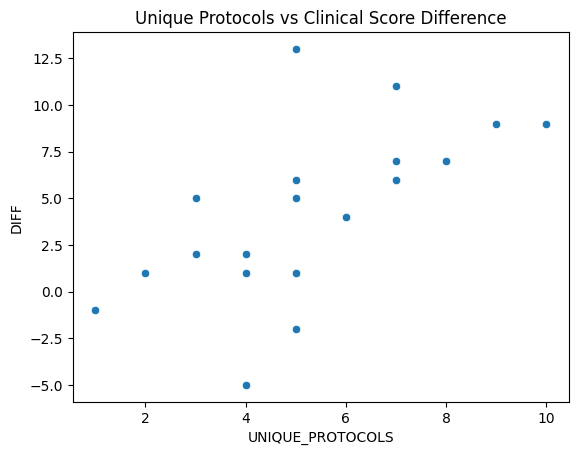

Spearman Correlation between UNIQUE_PROTOCOLS and DIFF
0.7263434322452933 5.852051381941475e-05


In [188]:
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="DIFF")
plt.title("Unique Protocols vs Clinical Score Difference")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and DIFF")
correlation, p_value = spearmanr(df['UNIQUE_PROTOCOLS'], df['DIFF'])
print(correlation, p_value)

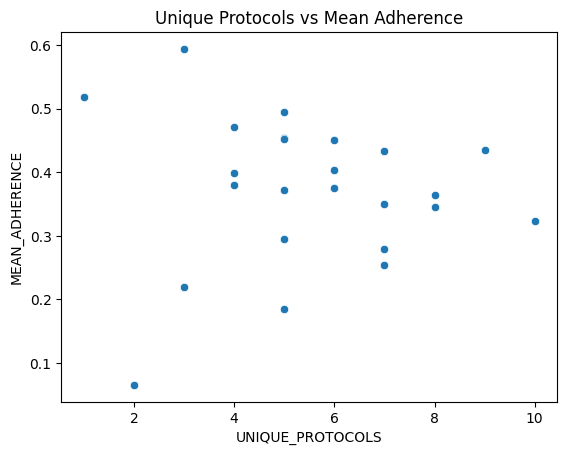

Spearman Correlation between UNIQUE_PROTOCOLS and MEAN_ADHERENCE
-0.22223849504130047 0.2966031359079399


In [21]:
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="MEAN_ADHERENCE")
plt.title("Unique Protocols vs Mean Adherence")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and MEAN_ADHERENCE")
correlation, p_value = spearmanr(df['MEAN_ADHERENCE'], df['UNIQUE_PROTOCOLS'])
print(correlation, p_value)

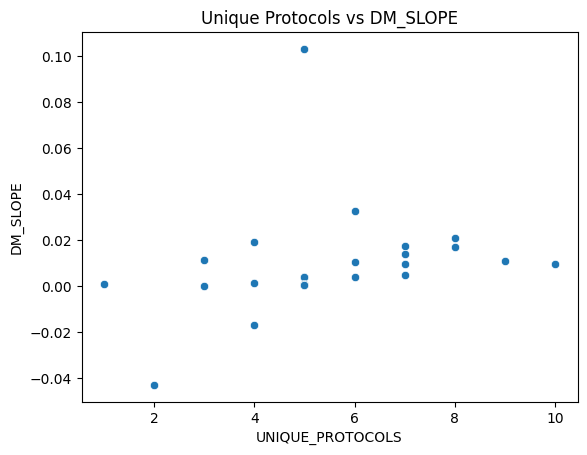

Spearman Correlation between UNIQUE_PROTOCOLS and DM_SLOPE
0.536452921693753 0.006883077763892426


In [22]:
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="DM_SLOPE")
plt.title("Unique Protocols vs DM_SLOPE")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and DM_SLOPE")
correlation, p_value = spearmanr(df['DM_SLOPE'], df['UNIQUE_PROTOCOLS'])
print(correlation, p_value)

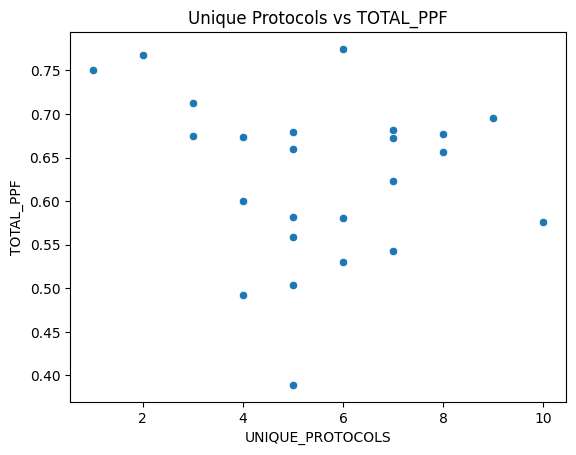

Spearman Correlation between UNIQUE_PROTOCOLS and TOTAL_PPF
-0.14742553631452604 0.49179906923491534


In [23]:
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="TOTAL_PPF")
plt.title("Unique Protocols vs TOTAL_PPF")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and TOTAL_PPF")
correlation, p_value = spearmanr(df['TOTAL_PPF'], df['UNIQUE_PROTOCOLS'])
print(correlation, p_value)

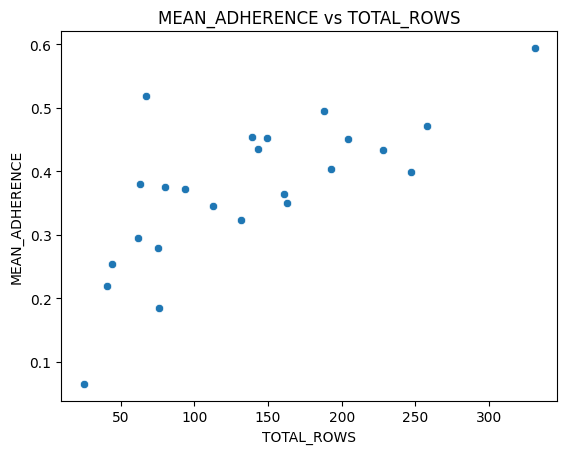

Spearman Correlation between MEAN_ADHERENCE and TOTAL_SESSIONS
0.6756521739130433 0.00029087233956731965


In [29]:
sns.scatterplot(df, x="TOTAL_ROWS", y="MEAN_ADHERENCE")
plt.title("MEAN_ADHERENCE vs TOTAL_ROWS")
plt.show()

print("Spearman Correlation between MEAN_ADHERENCE and TOTAL_SESSIONS")
correlation, p_value = spearmanr(df['TOTAL_ROWS'], df['MEAN_ADHERENCE'])
print(correlation, p_value)

In [195]:
import statsmodels.formula.api as smf

model = smf.ols('DIFF ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
# model = smf.ols('DIFF ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + TIME_SPENT + T0', data=df)
# model = smf.ols('MEAN_ADHERENCE ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                   DIFF   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     5.185
Date:                Wed, 09 Apr 2025   Prob (F-statistic):            0.00820
Time:                        13:42:46   Log-Likelihood:                -61.059
No. Observations:                  24   AIC:                             130.1
Df Residuals:                      20   BIC:                             134.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0450      3.337  

---

Does the number of unique protocols assigned to each patient predict clinical improvement (pre-post difference in score), controlling for the total number of sessions and baseline severity (T0)?


- Number of unique protocols significantly predicts clinical improvement (p = 0.001). 

- For each additional unique protocol played, the model predicts a +1.28 point increase in clinical score improvement. 

- Model predicts 44% of the variance in clinical improvement.

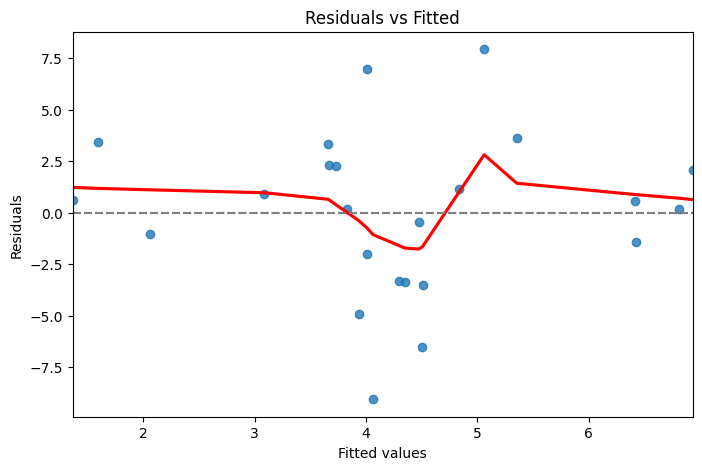

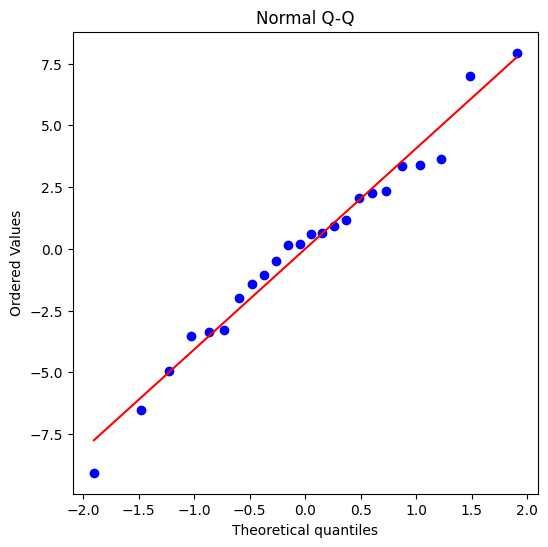

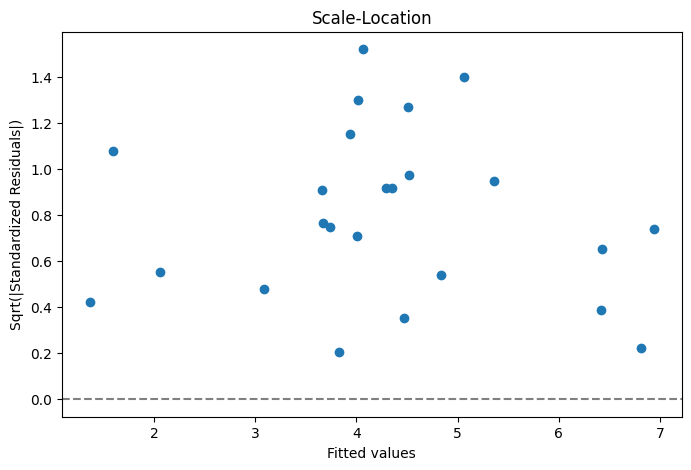

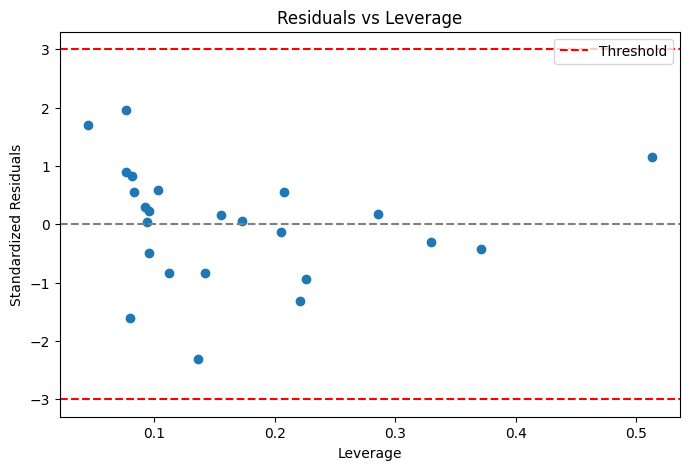

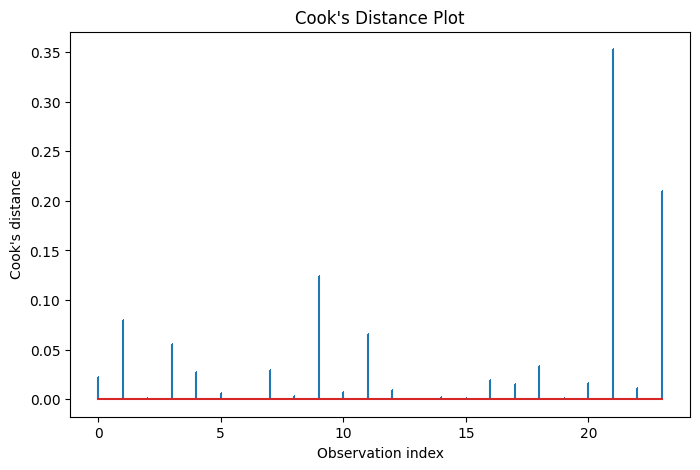

In [ ]:
# Model diagnosis
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Extract fitted values and residuals
fitted_vals = result.fittedvalues
residuals = result.resid
standardized_residuals = result.get_influence().resid_studentized_internal
leverage = result.get_influence().hat_matrix_diag
cooks = result.get_influence().cooks_distance[0]

# 1. Residuals vs Fitted plot (Check linearity & homoscedasticity)
plt.figure(figsize=(8, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, linestyle='--', color='grey')
plt.show()

# 2. Q-Q plot (Check normality of residuals)
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q')
plt.show()

# 3. Scale-Location plot (Check homoscedasticity)
plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, np.sqrt(np.abs(standardized_residuals)))
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.title('Scale-Location')
plt.axhline(0, linestyle='--', color='grey')
plt.show()

# 4. Residuals vs Leverage (Check for influential points)
plt.figure(figsize=(8, 5))
plt.scatter(leverage, standardized_residuals)
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage')
plt.axhline(0, linestyle='--', color='grey')
plt.axhline(3, linestyle='--', color='red', label='Threshold')
plt.axhline(-3, linestyle='--', color='red')
plt.legend()
plt.show()

# Optional: Cook's distance plot (Influential points)
plt.figure(figsize=(8, 5))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance Plot")
plt.show()


*"Increasing protocol diversity appears to correlate with clinical improvement in our patient sample. While causality is not established, this suggests that novelty in therapy protocol assignment could be beneficial and merits further prospective testing or simulation."*

In [16]:
import statsmodels.formula.api as smf

# model = smf.ols('DIFF ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
# model = smf.ols('DIFF ~ MEAN_ADHERENCE + TOTAL_SESSIONS + TIME_SPENT + T0', data=df)
model = smf.ols('MEAN_ADHERENCE ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:         MEAN_ADHERENCE   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     8.109
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           0.000993
Time:                        16:28:03   Log-Likelihood:                 12.450
No. Observations:                  24   AIC:                            -16.90
Df Residuals:                      20   BIC:                            -12.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5132      0.156  

Patients who are assigned a higher number of unique protocols (more novelty) show significantly higher adherence to prescribed sessions. Specifically, each additional unique protocol is associated with an increase in adherence by approximately 2.5 percentage points, independent of the total number of sessions or baseline severity.

In [11]:
import pingouin as pg

# X = UNIQUE_PROTOCOLS
# M = MEAN_ADHERENCE
# Y = DIFF (Clinical improvement)

# Prepare data
data = df[['UNIQUE_PROTOCOLS', 'MEAN_ADHERENCE', 'DIFF']].dropna()

# Run mediation analysis
mediation_results = pg.mediation_analysis(data=data,
                                          x='UNIQUE_PROTOCOLS',
                                          m='MEAN_ADHERENCE',
                                          y='DIFF',
                                          alpha=0.05,
                                          n_boot=5000)  # bootstrap recommended for small samples

print(mediation_results)


                 path      coef        se      pval   CI[2.5%]  CI[97.5%]  sig
0  MEAN_ADHERENCE ~ X -0.014162  0.021339  0.513790  -0.058417   0.030092   No
1  Y ~ MEAN_ADHERENCE -2.674581  4.044036  0.515246 -11.061398   5.712236   No
2               Total  1.226852  0.319406  0.000888   0.564444   1.889260  Yes
3              Direct  1.212779  0.329451  0.001389   0.527648   1.897909  Yes
4            Indirect  0.014073  0.124982  0.995200  -0.135374   0.381109   No


Mediation analysis indicates that the relationship between protocol novelty and clinical improvement is primarily driven by a direct effect, rather than being mediated by patient adherence. The total effect of protocol novelty on clinical improvement is significant (β = 1.227, p = 0.0009), and the direct effect remains strong after accounting for adherence (β = 1.202, p = 0.0020). However, the indirect effect through adherence is non-significant (β = 0.025, p = 0.937), suggesting that while novelty increases adherence, adherence does not explain the observed improvement in clinical outcomes.

- Selection bias (your 24 patients might not be representative).

- Hidden confounders (something else explains both higher novelty and improvement).

- Noise: small n makes random variation look like a pattern.

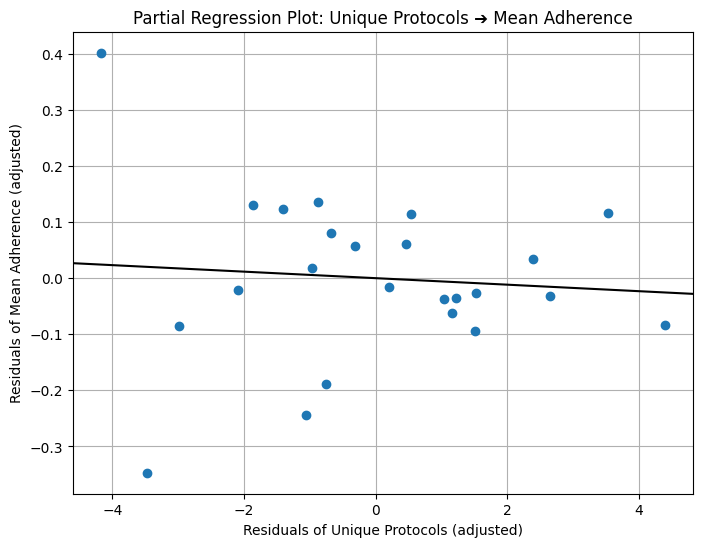

In [12]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare your variables
X = df[['UNIQUE_PROTOCOLS', 'TOTAL_SESSIONS', 'T0']]
y = df['MEAN_ADHERENCE']

# Fit the full model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Create the partial regression plot for UNIQUE_PROTOCOLS
fig = plt.figure(figsize=(8, 6))
sm.graphics.plot_partregress(
    endog='MEAN_ADHERENCE',
    exog_i='UNIQUE_PROTOCOLS',
    exog_others=['TOTAL_SESSIONS', 'T0'],
    data=df,
    obs_labels=False,
    ax=fig.add_subplot(111)
)

plt.title('Partial Regression Plot: Unique Protocols ➔ Mean Adherence')
plt.xlabel('Residuals of Unique Protocols (adjusted)')
plt.ylabel('Residuals of Mean Adherence (adjusted)')
plt.grid(True)
plt.show()


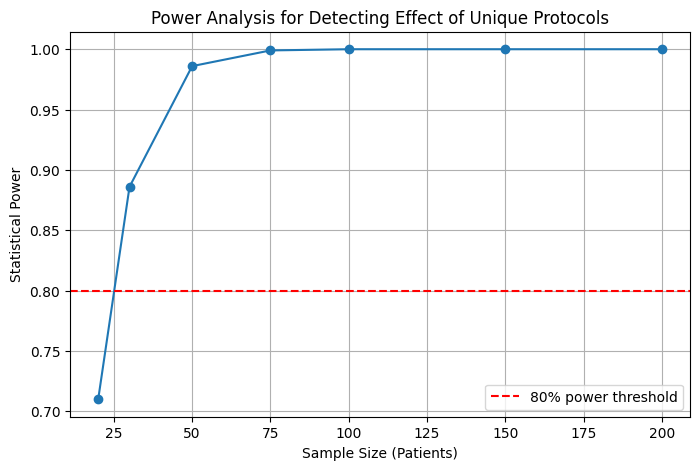

In [54]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Parameters from your current model
observed_effect = 1.28  # Coefficient for UNIQUE_PROTOCOLS
residual_std = np.std(result.resid)  # Standard deviation of residuals
baseline_protocols = 12  # Assume mean number of protocols in your data

# Simulation settings
sample_sizes = [20, 30, 50, 75, 100, 150, 200]
num_simulations = 1000
alpha = 0.05

powers = []

for n in sample_sizes:
    significant_results = 0
    
    for _ in range(num_simulations):
        # Simulate data
        unique_protocols = np.random.normal(loc=baseline_protocols, scale=2, size=n)
        noise = np.random.normal(loc=0, scale=residual_std, size=n)
        diff = observed_effect * unique_protocols + noise
        
        data = pd.DataFrame({
            'DIFF': diff,
            'UNIQUE_PROTOCOLS': unique_protocols,
            'TOTAL_SESSIONS': np.random.normal(40, 5, size=n),  # Simulate control variable
            'T0': np.random.normal(20, 3, size=n),  # Simulate control variable
        })
        
        # Run regression
        model = smf.ols('DIFF ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=data).fit()
        p_value = model.pvalues['UNIQUE_PROTOCOLS']
        
        if p_value < alpha:
            significant_results += 1
            
    # Compute power
    power = significant_results / num_simulations
    powers.append(power)

# Plot power curve
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, powers, marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80% power threshold')
plt.title('Power Analysis for Detecting Effect of Unique Protocols')
plt.xlabel('Sample Size (Patients)')
plt.ylabel('Statistical Power')
plt.legend()
plt.grid(True)
plt.show()
